# 1. Préliminaires

## 1.1. Importations

Importons les bibliothèques :

In [1]:
import random
import timeit
import os
import shutil

# Data
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Split
from sklearn.model_selection import train_test_split

# Label encoder
from sklearn.preprocessing import LabelEncoder

# Classification
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from plot_keras_history import show_history, plot_history

Chargeons les données :

In [2]:
df = pd.read_csv('Flipkart/df_cleaned.csv')

## 1.2. Présentation des données

Forme du tableau :

In [3]:
df.shape

(1050, 3)

Tête de la table (5 premières lignes) :

In [4]:
df.head()

,category,image_path,name_and_description
0,Home Furnishing,Flipkart/Images/55b85ea15a1536d46b7190ad6fff8c...,Elegance Polyester Multicolor Abstract Eyelet ...
1,Baby Care,Flipkart/Images/7b72c92c2f6c40268628ec5f14c6d5...,Sathiyas Cotton Bath Towel Specifications of S...
2,Baby Care,Flipkart/Images/64d5d4a258243731dc7bbb1eef49ad...,Eurospa Cotton Terry Face Towel Set Key Featur...
3,Home Furnishing,Flipkart/Images/d4684dcdc759dd9cdf41504698d737...,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Home Furnishing,Flipkart/Images/6325b6870c54cd47be6ebfbffa620e...,Jaipur Print Cotton Floral King sized Double B...


## 1.3. Graines aléatoires

In [5]:
# Fixation de toutes les graines aléatoires (Python, NumPy et TensorFlow)
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## 1.4. Préparation de data et de data_test

Les 7 catégories de notre jeu de données sont en proportions égales. Chaque catégorie contient 150 individus. Alors pour séparer notre jeu de données en deux (data et data_test), nous allons appliquer une stratification afin d'éviter l'introduction de biais.

In [6]:
data, data_test = train_test_split(df, test_size=0.2, stratify=df['category'])

### 1.4.1. data

In [7]:
data.shape

(840, 3)

In [8]:
data.head()

,category,image_path,name_and_description
689,Kitchen & Dining,Flipkart/Images/55195de3873fffaa9e37b041533d73...,Philips 9.5 W LED B22 3000K A55 IND Bulb Buy P...
56,Beauty and Personal Care,Flipkart/Images/24e85c590481a7cedfe66597f253f2...,Borse N16 Make Up And Jewellery Vanity Case Bu...
96,Home Decor & Festive Needs,Flipkart/Images/f12a06b7dbfc55638afafcf8bb03d8...,My Angel Gifts Show Piece Showpiece - 5 cm B...
326,Computers,Flipkart/Images/c75d6d827876b0d0127acb59e5a251...,TRENDnet TEW-752DRU Buy TRENDnet TEW-752DRU on...
864,Computers,Flipkart/Images/19d2dbc1789653c58bce08c169662c...,RCE HP ProBook 4430s 6 Cell Laptop Battery Buy...


In [9]:
data['category'].value_counts()

Baby Care                     120
Watches                       120
Kitchen & Dining              120
Home Furnishing               120
Home Decor & Festive Needs    120
Computers                     120
Beauty and Personal Care      120
Name: category, dtype: int64

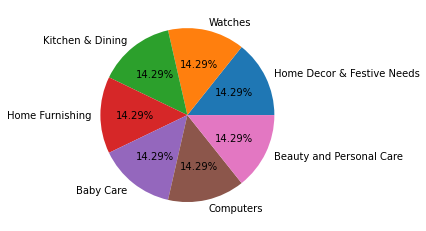

In [10]:
plt.pie(x=data['category'].value_counts(),
        labels=df['category'].value_counts().index,
        autopct='%1.2f%%')
plt.show()

### 1.4.2. data_test

In [11]:
data_test.shape

(210, 3)

In [12]:
data_test.head()

,category,image_path,name_and_description
276,Watches,Flipkart/Images/14826adf9bc4c34ea566dae3d85ef7...,Pittsburgh Polo Club PBPC-505-GRN Analog Watch...
1017,Home Furnishing,Flipkart/Images/4748b7ea0e01cffa561f1a7a7a4328...,Aroma Comfort Polyester Cream Self Design Eyel...
687,Beauty and Personal Care,Flipkart/Images/d61b368146f83075937e144dab93c6...,Jovees Anjeer & Carrot Sunblock (Pack of 2) - ...
897,Home Furnishing,Flipkart/Images/e1e2883b6845cb214ec8d365cd4960...,NKP Cotton Hand Towel NKP Cotton Hand Towel (H...
85,Home Decor & Festive Needs,Flipkart/Images/61c0139f3d5c97f1615797dbf046cc...,Smart Wall Guru Medium Adhesive Sticker Key Fe...


In [13]:
data_test['category'].value_counts()

Kitchen & Dining              30
Home Furnishing               30
Computers                     30
Home Decor & Festive Needs    30
Beauty and Personal Care      30
Watches                       30
Baby Care                     30
Name: category, dtype: int64

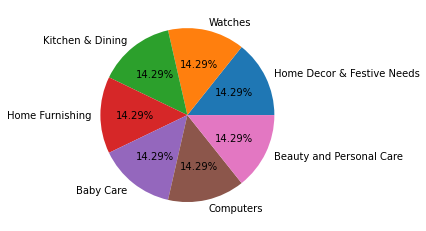

In [14]:
plt.pie(x=data_test['category'].value_counts(),
        labels=df['category'].value_counts().index,
        autopct='%1.2f%%')
plt.show()

# 2. Classification supervisée

Dans le but d'effectuer de la classification supervisée, nous allons réaliser du transfert learning, qui consiste à utiliser des modèles pré-entraînés. Nous emploierons notamment le modèle VGG-16 qui est un réseau de neurones à convolution (CNN) pré-entraîné sur ImageNet.

Pour entraîner et évaluer chaque modèle d'apprentissage profond, nous réaliserons la séparation des données de la manière suivante :
- Jeu d'entraînement : afin d'entraîner le modèle
- Jeu de validation : afin d'optimiser la fonction de perte (loss) qui sera l'entropie croisée (cross-entropy).
- Jeu de test : afin d'évaluer la performance du modèle sur de nouvelles données.

Pour évaluer la performance de nos modèles d'apprentissage profond, nous ferons appel aux critères suivants :
 - Accuracy : Calcul de la proportion d'étiquettes prédites équivalentes aux vrais étiquettes. Nous estimerons plus particulièrement l'accuracy sur le jeu de test.
 - Temps d'entraînement : Le temps nécessaire pour l'entraînement du modèle.

In [15]:
score_df = pd.DataFrame(
    columns=['Approche','Fit Time', 'Accuracy'])
score_df.set_index('Approche', inplace=True)

## 2.1. Approche par préparation initiale des images

**Modèle de classification**

Nous allons créer un modèle de classification à partir du modèle VGG-16. Pour cela, nous allons retirer les dernières couches du modèle VGG-16 et garder les poids des premières couches (les couches restantes). Ensuite nous allons ajouter un nouveau classifieur à ce modèle tronqué pour le compléter. Par la suite, nous entraînerons uniquement le nouveau classifieur.

In [16]:
def create_model():
    # Chargement de VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    model0 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Conservation des poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False
    
    # Récupération de la sortie de ce réseau
    x = model0.output

    # Complétion du modèle
    x = GlobalAveragePooling2D()(x)  # Average pooling
    x = Dense(256, activation='relu')(x)  # Correction ReLu
    x = Dropout(0.5)(x)  # Attribution de la valeur 0 à la moitié des entrées
    predictions = Dense(7, activation='softmax')(x)  # Classification à 7 classes

    # Définition du nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)

    # Compilation du modèle
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [17]:
model1 = create_model()
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Préparation initiale des images**

In [18]:
def img_prep(col):
    # Liste vide pour enregistrer les images converties en vecteurs
    prepared_img = []

    for i in col:
        # Chargement et redimensionnement de l'image
        img = load_img(i, target_size=(224, 224))

        # Conversion en array (numpy)
        img = img_to_array(img)

        # Changement de la forme de l'image
        img = img.reshape(
            (img.shape[0],  # Largeur
             img.shape[1],  # Hauteur
             img.shape[2])  # Profondeur
        )
        
        # Prétraitement de l'image comme le veut VGG-16
        img = preprocess_input(img)
        
        # Enregistrement de l'image convertie en vecteur
        prepared_img.append(img)
    
    # Conversion de la liste en array
    prepared_img = np.array(prepared_img)
    
    return prepared_img

In [19]:
y = LabelEncoder().fit_transform(data['category'])
y = to_categorical(y)

X = img_prep(data['image_path'])

# Séparation du jeu d'entraînement et du jeu de validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.25)

Jeu d'entraînement :

In [20]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (630, 224, 224, 3)
y_train: (630, 7)


Jeu de validation :

In [21]:
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_val: (210, 224, 224, 3)
y_val: (210, 7)


Jeu de test :

In [22]:
y_test = LabelEncoder().fit_transform(data_test['category'])
y_test = to_categorical(y_test)

X_test = img_prep(data_test['image_path'])

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

C:\Users\mauri\.conda\envs\pro6\lib\site-packages\PIL\Image.py:2914: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


X_test: (210, 224, 224, 3)
y_test: (210, 7)


**Entraînement**

In [23]:
def create_callbacks(path):
    checkpoint = ModelCheckpoint(
        path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    callbacks_list = [checkpoint, es]

    return callbacks_list

In [24]:
# Création des callbacks
model1_save_path = './model1_best_weights.h5'
callbacks_list = create_callbacks(model1_save_path)

In [25]:
# Entraînement du modèle sur les données d'entraînement (X_train, y_train) et mesure du temps
start_time = timeit.default_timer()
history1 = model1.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      callbacks=callbacks_list,
                      validation_data=(X_val, y_val),
                      verbose=1)
stop_time = timeit.default_timer()

Epoch 1/50
20/20 [==============================] - 167s 8s/step - loss: 5.0628 - accuracy: 0.4444 - val_loss: 1.4182 - val_accuracy: 0.7714

Epoch 00001: val_loss improved from inf to 1.41818, saving model to .\model1_best_weights.h5
Epoch 2/50
20/20 [==============================] - 166s 8s/step - loss: 1.8255 - accuracy: 0.6825 - val_loss: 1.2522 - val_accuracy: 0.7905

Epoch 00002: val_loss improved from 1.41818 to 1.25220, saving model to .\model1_best_weights.h5
Epoch 3/50
20/20 [==============================] - 169s 9s/step - loss: 1.0536 - accuracy: 0.7698 - val_loss: 1.1576 - val_accuracy: 0.7857

Epoch 00003: val_loss improved from 1.25220 to 1.15756, saving model to .\model1_best_weights.h5
Epoch 4/50
20/20 [==============================] - 170s 9s/step - loss: 0.7834 - accuracy: 0.8048 - val_loss: 1.1474 - val_accuracy: 0.7714

Epoch 00004: val_loss improved from 1.15756 to 1.14742, saving model to .\model1_best_weights.h5
Epoch 5/50
20/20 [==============================

In [26]:
# Temps d'entraînement
fit_time = stop_time - start_time
print("Fit Time: {:.0f}s | {:.2f}min".format(fit_time, fit_time/60))

Fit Time: 1858s | 30.97min


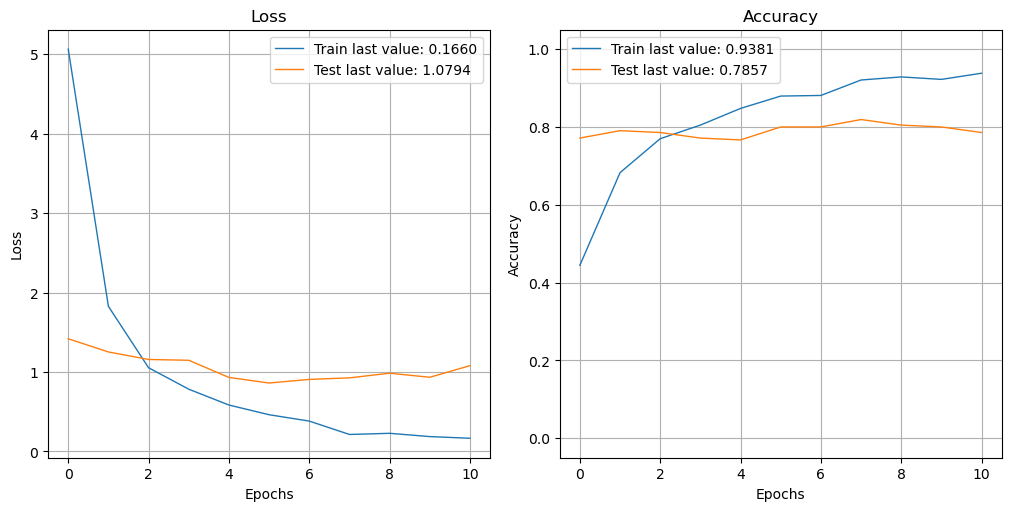

In [27]:
show_history(history1)

Sur ce graphique, nous pouvons voir que la perte du jeu d'entraînement diminue en fonction des itérations (epochs), tandis que la perte du jeu de test arrête rapidement de diminuer (d'où l'arrêt précoce des itérations). Par conséquent, nous avons un problème de sur-apprentissage.

In [28]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8000
Test Accuracy       :  0.8333


L'accuracy du jeu de test (pour l'epoch optimal) est décente et est proche de celle du jeu de validation.

In [29]:
# Enregistrement du temps d'entraînement et de l'accuracy (sur le jeu de test)
score_df.loc['Préparation initiale des images'] = [fit_time, accuracy]

## 2.2. Approche par ImageDataGenerator avec data augmentation

**Modèle de classification**

In [30]:
model2 = create_model()
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

**ImageDataGenerator**

In [31]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

In [32]:
def flow_from_df(df, datagen, data_type=None):
    flow = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='category',
        target_size=(256, 256),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        subset=data_type)
    
    return flow

In [33]:
# Jeu d'entraînement
flow_train = flow_from_df(df=data, datagen=datagen_train, data_type='training')

# Jeu de validation
flow_val = flow_from_df(df=data, datagen=datagen_train, data_type='validation')

# Jeu de test
flow_test = flow_from_df(df=data_test, datagen=datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


**Entraînement**

In [34]:
# Création des callbacks
model2_save_path = './model2_best_weights.h5'
callbacks_list = create_callbacks(model2_save_path)

In [35]:
# Entraînement du modèle et mesure du temps
start_time = timeit.default_timer()
history2 = model2.fit(flow_train,
                      validation_data=flow_val,
                      epochs=50,
                      batch_size=32,
                      callbacks=callbacks_list,
                      verbose=1)
stop_time = timeit.default_timer()

Epoch 1/50
20/20 [==============================] - 227s 11s/step - loss: 4.1333 - accuracy: 0.4587 - val_loss: 1.2776 - val_accuracy: 0.7048

Epoch 00001: val_loss improved from inf to 1.27762, saving model to .\model2_best_weights.h5
Epoch 2/50
20/20 [==============================] - 225s 11s/step - loss: 1.6177 - accuracy: 0.6667 - val_loss: 1.3136 - val_accuracy: 0.7238

Epoch 00002: val_loss did not improve from 1.27762
Epoch 3/50
20/20 [==============================] - 228s 11s/step - loss: 1.0177 - accuracy: 0.7508 - val_loss: 1.0999 - val_accuracy: 0.7190

Epoch 00003: val_loss improved from 1.27762 to 1.09992, saving model to .\model2_best_weights.h5
Epoch 4/50
20/20 [==============================] - 227s 11s/step - loss: 0.7788 - accuracy: 0.7810 - val_loss: 1.0982 - val_accuracy: 0.7381

Epoch 00004: val_loss improved from 1.09992 to 1.09821, saving model to .\model2_best_weights.h5
Epoch 5/50
20/20 [==============================] - 225s 11s/step - loss: 0.6065 - accurac

In [36]:
# Temps d'entraînement
fit_time = stop_time - start_time
print("Fit Time: {:.0f}s | {:.2f}min".format(fit_time, fit_time/60))

Fit Time: 3386s | 56.43min


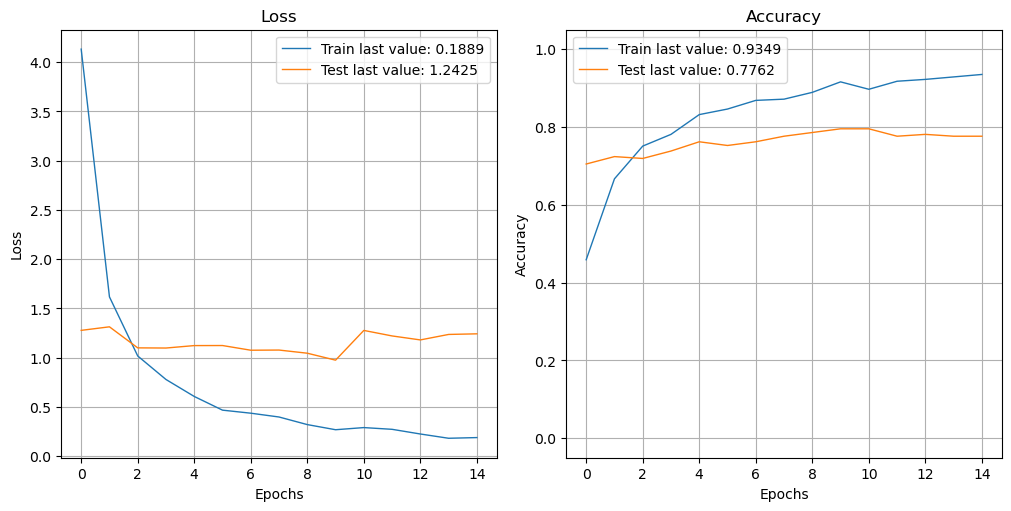

In [37]:
show_history(history2)

Sur ce graphique, nous constatons que la perte du jeu d'entraînement diminue en fonction des itérations, alors que la perte du jeu de validation stagne (voire augmente) en fonction des itérations. Par conséquent, le modèle sur-apprend.

In [38]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(flow_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(flow_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7810


C:\Users\mauri\.conda\envs\pro6\lib\site-packages\PIL\Image.py:2914: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Test Accuracy       :  0.8429


L'accuracy du jeu de test est décente et est relativement proche de celle du jeu de validation.

In [39]:
# Enregistrement du temps d'entraînement et de l'accuracy (sur le jeu de test)
score_df.loc['ImageDataGenerator avec data augmentation'] = [fit_time, accuracy]

## 2.3. Approche nouvelle par Dataset sans data augmentation

**Modèle de classification**

In [40]:
model3 = create_model()
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

**Dataset**

Nous allons créer un répertoire de fichiers images (si inexistant) afin de pouvoir générer les Dataset. Pour cela, nous utiliserons nos données `data` et `data_test`.

In [41]:
path = './Flipkart/Images_per_category'

if not os.path.exists(path):
    # Pour chaque catégorie
    for category in df['category'].unique():
        # Création d'un nouveau sous-dossier pour data
        data_folder = f'{path}/data/{category}'
        os.makedirs(data_folder)

        # Création d'un nouveau sous-dossier pour data_test
        data_test_folder = f'{path}/data_test/{category}'
        os.makedirs(data_test_folder)

        # Images de data appartenant à la catégorie
        data_paths = data.loc[data['category'] == category, 'image_path']
        
        # Images de data_test appartenant à la catégorie
        data_test_paths = data_test.loc[data_test['category'] == category, 'image_path']

        # Copie de chacune des images de data_paths vers le nouveau sous-dossier dans data
        for img_path in data_paths:
            shutil.copy(img_path, data_folder)

        # Copie de chacune des images de data_test_paths vers le nouveau sous-dossier dans data_test
        for img_path in data_test_paths:
            shutil.copy(img_path, data_test_folder)

Fonction permettant de générer les Dataset :

In [42]:
def dataset(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=1,
        validation_split=validation_split,
        subset=data_type)

    return dataset

In [43]:
data_path = './Flipkart/Images_per_category/data'
data_test_path = './Flipkart/Images_per_category/data_test'

# Jeu d'entraînement
dataset_train = dataset(data_path, validation_split=0.25, data_type='training')

# Jeu de validation
dataset_val = dataset(data_path, validation_split=0.25, data_type='validation')

# Jeu de test
dataset_test = dataset(data_test_path, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


**Entraînement**

In [44]:
# Création des callbacks
model3_save_path = './model3_best_weights.h5'
callbacks_list = create_callbacks(model3_save_path)

In [45]:
# Entraînement du modèle et mesure du temps
start_time = timeit.default_timer()
history3 = model3.fit(dataset_train,
                      validation_data=dataset_val,
                      epochs=50,
                      batch_size=32,
                      callbacks=callbacks_list,
                      verbose=1)
stop_time = timeit.default_timer()

Epoch 1/50
20/20 [==============================] - 175s 9s/step - loss: 6.5449 - accuracy: 0.4508 - val_loss: 1.4723 - val_accuracy: 0.7238

Epoch 00001: val_loss improved from inf to 1.47235, saving model to .\model3_best_weights.h5
Epoch 2/50
20/20 [==============================] - 173s 9s/step - loss: 2.5196 - accuracy: 0.6270 - val_loss: 0.9840 - val_accuracy: 0.7905

Epoch 00002: val_loss improved from 1.47235 to 0.98401, saving model to .\model3_best_weights.h5
Epoch 3/50
20/20 [==============================] - 172s 9s/step - loss: 1.4699 - accuracy: 0.7127 - val_loss: 0.9829 - val_accuracy: 0.7952

Epoch 00003: val_loss improved from 0.98401 to 0.98286, saving model to .\model3_best_weights.h5
Epoch 4/50
20/20 [==============================] - 172s 9s/step - loss: 1.0326 - accuracy: 0.7635 - val_loss: 0.7922 - val_accuracy: 0.8476

Epoch 00004: val_loss improved from 0.98286 to 0.79220, saving model to .\model3_best_weights.h5
Epoch 5/50
20/20 [==============================

In [46]:
# Temps d'entraînement
fit_time = stop_time - start_time
print("Fit Time: {:.0f}s | {:.2f}min".format(fit_time, fit_time/60))

Fit Time: 1896s | 31.60min


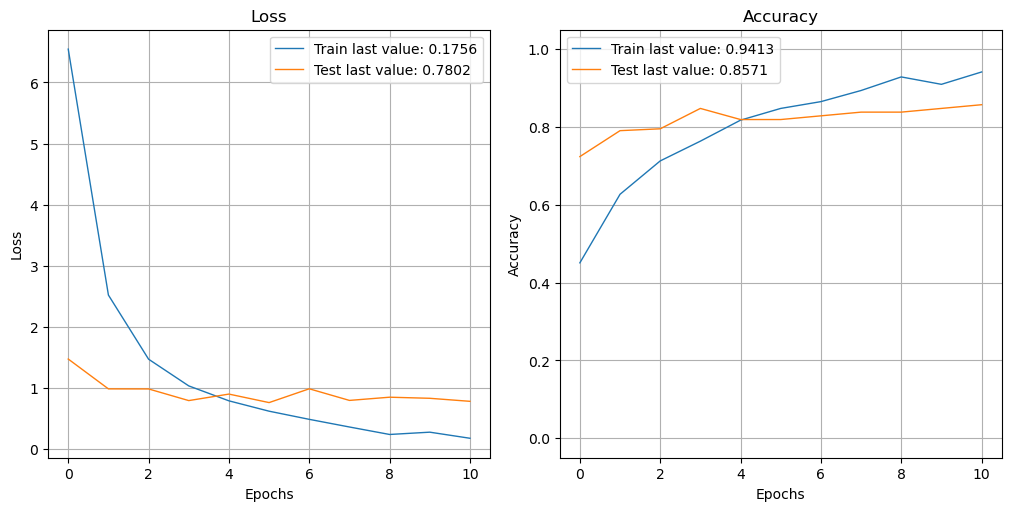

In [47]:
show_history(history3)

Sur ce graphique, nous remarquons que la perte du jeu d'entraînement diminue avec les epochs, tandis que la perte du jeu de validation stagne avec les epochs. Par conséquent, le modèle sur-apprend.

In [48]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8190
Test Accuracy       :  0.8286


L'accuracy du jeu de test est décente et très proche de celle du jeu de validation.

In [49]:
# Enregistrement du temps d'entraînement et de l'accuracy (sur le jeu de test)
score_df.loc['Dataset sans data augmentation'] = [fit_time, accuracy]

## 2.4. Approche nouvelle par Dataset avec data augmentation intégrée au modèle

**Modèle de classification**

In [50]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal', input_shape=(224, 224, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Chargement de VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Conservation des poids du modèle pré-entraîné
for layer in model_base.layers:
    layer.trainable = False
    
# Définition du nouveau modèle
model4 = Sequential([
    data_augmentation,
    Rescaling(1./127.5, offset=-1),  # Redimensionnement
    model_base,
    GlobalAveragePooling2D(),  # Average pooling
    Dense(256, activation='relu'),  # Correction ReLu
    Dropout(0.5),  # Attribution de la valeur 0 à la moitié des entrées
    Dense(7, activation='softmax')  # Classification à 7 classes
])

# Compilation du modèle
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                

**Dataset**

Nous pouvons reprendre nos jeux de données suivants :
- `dataset_train` : Jeu d'entraînement
- `dataset_val` : Jeu de validation
- `dataset_test` : Jeu de test

**Entraînement**

In [51]:
# Création des callbacks
model4_save_path = './model4_best_weights.h5'
callbacks_list = create_callbacks(model4_save_path)

In [52]:
# Entraînement du modèle et mesure du temps
start_time = timeit.default_timer()
history4 = model4.fit(dataset_train,
                      validation_data=dataset_val,
                      epochs=50,
                      batch_size=32,
                      callbacks=callbacks_list,
                      verbose=1)
stop_time = timeit.default_timer()

Epoch 1/50
20/20 [==============================] - 176s 9s/step - loss: 1.8308 - accuracy: 0.3000 - val_loss: 1.3948 - val_accuracy: 0.5571

Epoch 00001: val_loss improved from inf to 1.39475, saving model to .\model4_best_weights.h5
Epoch 2/50
20/20 [==============================] - 173s 9s/step - loss: 1.3724 - accuracy: 0.5079 - val_loss: 1.1266 - val_accuracy: 0.6810

Epoch 00002: val_loss improved from 1.39475 to 1.12663, saving model to .\model4_best_weights.h5
Epoch 3/50
20/20 [==============================] - 174s 9s/step - loss: 1.2094 - accuracy: 0.6048 - val_loss: 1.0134 - val_accuracy: 0.6952

Epoch 00003: val_loss improved from 1.12663 to 1.01337, saving model to .\model4_best_weights.h5
Epoch 4/50
20/20 [==============================] - 174s 9s/step - loss: 1.0602 - accuracy: 0.6762 - val_loss: 0.8505 - val_accuracy: 0.7905

Epoch 00004: val_loss improved from 1.01337 to 0.85051, saving model to .\model4_best_weights.h5
Epoch 5/50
20/20 [==============================

In [53]:
# Temps d'entraînement
fit_time = stop_time - start_time
print("Fit Time: {:.0f}s | {:.2f}min".format(fit_time, fit_time/60))

Fit Time: 2609s | 43.49min


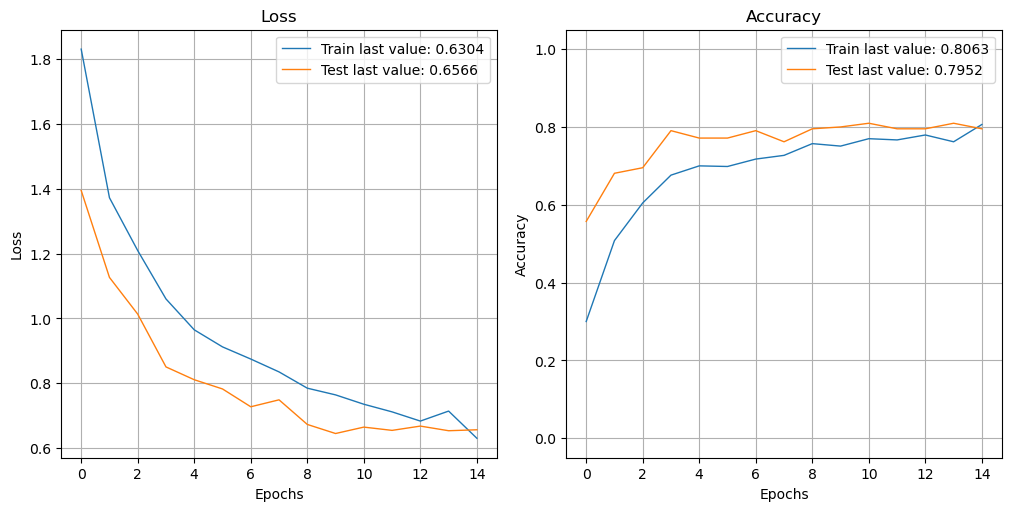

In [54]:
show_history(history4)

Sur ce graphique, nous observons que la perte du jeu d'entraînement et celle du jeu de test diminuent toutes les deux avec les epochs. L'écart entre les deux courbes est faible. Par conséquent, nous n'avons pas de problème majeur de sur-apprentissage (ou de sous-apprentissage).

In [55]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8000
Test Accuracy       :  0.7810


L'accuracy du jeu de test est décente et proche de celle du jeu de validation.

In [56]:
# Enregistrement du temps d'entraînement et de l'accuracy (sur le jeu de test)
score_df.loc['Dataset avec data augmentation intégrée au modèle'] = [fit_time, accuracy]

# 3. Synthèse

Tableau de comparaison des modèles :

In [57]:
score_df.round(4)

,Fit Time,Accuracy
Approche,,
Préparation initiale des images,1858.3929,0.8333
ImageDataGenerator avec data augmentation,3385.6506,0.8429
Dataset sans data augmentation,1896.0700,0.8286
Dataset avec data augmentation intégrée au modèle,2609.4327,0.7810


In [58]:
# Conversion du temps d'entraînement en minutes
time_min = score_df['Fit Time'] / 60
time_min.round(2)

Approche
Préparation initiale des images                      30.97
ImageDataGenerator avec data augmentation            56.43
Dataset sans data augmentation                       31.60
Dataset avec data augmentation intégrée au modèle    43.49
Name: Fit Time, dtype: float64

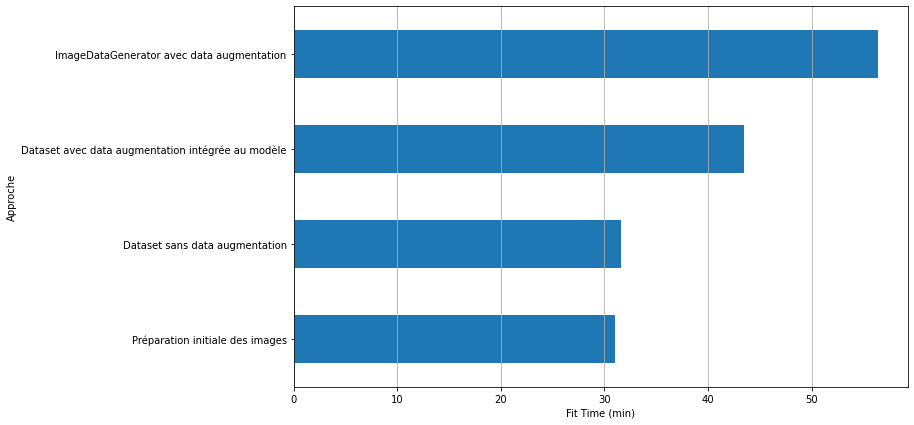

In [59]:
# Création d'un bar plot (horizontal) à partir des valeurs de temps par ordre croissant
time_min.sort_values(ascending=True).plot(kind='barh', figsize=(11, 7))

# Label, grille et affichage
plt.xlabel('Fit Time (min)')
plt.grid(axis='x')
plt.show()

Les approches les plus simples, c'est-à-dire celles sans data augmentation, ont les temps d'entraînement les plus petits (environ une trentaine de minutes). En effet, les approches plus complexes, c'est-à-dire celles avec data augmentation, ont des temps d'entraînement plus longs (environ 45 minutes ou 1 heure).

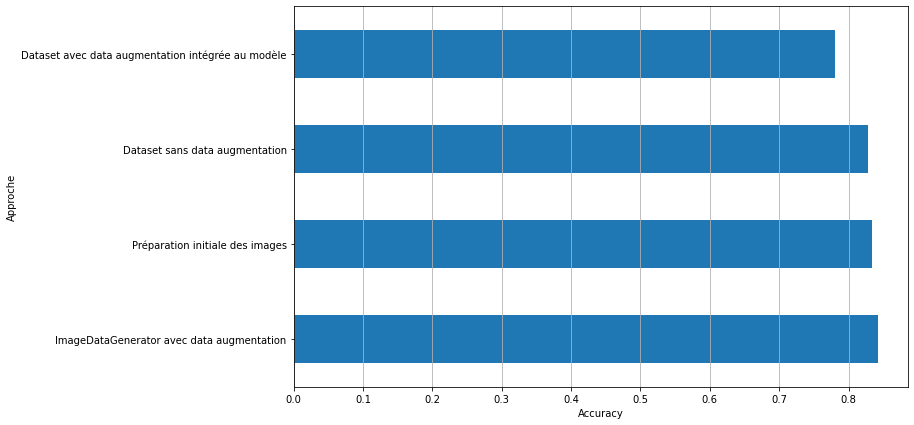

In [60]:
# # Création d'un bar plot (horizontal) à partir des valeurs d'accuracy par ordre décroissant
score_df['Accuracy'].sort_values(ascending=False).plot(kind='barh', figsize=(11, 7))

# Label, grille et affichage
plt.xlabel('Accuracy')
plt.grid(axis='x')
plt.show()

L'approche "ImageDataGenerator avec data augmentation" a l'accuracy la plus élevée. Puisque l'accuracy a été mesuré sur le jeu de test, alors cette approche est la plus performante sur de nouvelles données.